# Final Project Code Part 1: AE On MNIST

**Name: Yiqun Hao**

**Content**: In this notebook:

1. I rewrote the code from the paper "Deep Learning for Case-Based Reasoning through Prototypes:A Neural Network that Explains Its Predictions" with Pytorch because the original code is too old and it is in Tensorflow.

2. I did experiments on MNIST: the dataset the author used in the paper.

#### Import all packages used in this notebook

In [89]:
# Main package: PyTorch
import torch
# TorchVision contains image datasets
import torchvision
# Our networks
import torch.nn as nn
# Our activation
import torch.nn.functional as F
# Optimizer
import torch.optim as optim

# Draw graphs to visualize
import matplotlib.pyplot as plt
import numpy as np

#### 0. Check GPU

In [90]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


#### CAE Model Parameters

In [91]:
# lambda's are the ratios between the four error terms
# lambda_class = 20
lambda_class = 1
lambda_ae = 4
lambda_1 = 1              # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# the number of prototypes
n_prototypes = 10



#### 1. We first import dataset

In [92]:
n_epochs = 300
batch_size = 100
# learning_rate = 0.005
learning_rate = 0.004
momentum = 0.5
random_seed = 1
torch.manual_seed(random_seed)

In [93]:
transform=torchvision.transforms.Compose([
    # To [0,1]
    torchvision.transforms.ToTensor(),
    # To [-1,1] first () is the mean of grey. Second () is the std of grey
    torchvision.transforms.Normalize(
    (0.1307,), (0.3081,))
])

train_set = torchvision.datasets.MNIST('./MNISTdataset/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = torchvision.datasets.MNIST('./MNISTdataset/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

#### 2. We construct our network 

##### 1. Encoder

In [94]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride = 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride = 2)
        self.conv3 = nn.Conv2d(32, 10, kernel_size=3, stride = 2)

    def forward(self, x):
        # Input: 1 * 28 * 28 = 784
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
            #         10, 2 2
        x = F.relu(self.conv3(x))
    
        return x
print(Encoder())

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2))
)


##### 2. Decoder

In [95]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(10, 32, kernel_size=4, stride=2)
    self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2)
    self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2)

  def forward(self, x):
    # Problem: need to check this shape
    x = x.view(-1, 10, 2, 2)
    
    
    x = F.relu(self.deconv1(x))


    x = F.relu(self.deconv2(x))
    
    
    x = F.relu(self.deconv3(x))
    
    return x
print(Decoder())

Decoder(
  (deconv1): ConvTranspose2d(10, 32, kernel_size=(4, 4), stride=(2, 2))
  (deconv2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (deconv3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
)


In [96]:
# class LastLayer(nn.Module):
#     def __init__(self):
#         super(LastLayer, self).__init__()
#         self.fl = nn.Linear(n_prototypes, 10, bias=False)

#     def forward(self, x):
#         x = self.fl(x)
#         return x
#     def showWeight(self):
#         print(self.fl.weight) 
# print(LastLayer())

##### 3. Prototype Classification Network

In [97]:
# Functions used to calculate the distance between encoded_input and prototype vectors
def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = list_of_norms(X).view(-1, 1)
    YY = list_of_norms(Y).view(1, -1)
    output = XX + YY - 2 * torch.matmul(X, Y.t())

    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X,2), axis=1)

In [98]:
class PCN(nn.Module):
  def __init__(self):
    super(PCN, self).__init__()
    self.prototype_feature_vectors = nn.Parameter(torch.rand(n_prototypes, 10*2*2))
#     self.weight = nn.Parameter(torch.randn(n_prototypes, 10))



# x.shape:  torch.Size([100, 10, 2, 2])
# feature_vectors.shape:  torch.Size([100, 40])
# prototype_feature_vectors.shape:  torch.Size([10, 40])
# feature_vector_distances.shape is the list of distances from each prototype to every x_i in the latent space:  torch.Size([10, 100])
# prototype_distances.shape is the list of distances from each x_i to every prototype in the latent space :  torch.Size([100, 10])
  def forward(self, x):
        
    # Flatten layer
    feature_vectors = x.view(-1, 10 * 2 * 2)
    
    # ----------------------------------------------------------------------------------------------------------
    # Prototype layer
    prototype_distances = list_of_distances(feature_vectors, self.prototype_feature_vectors)
    
    feature_vector_distances = list_of_distances(self.prototype_feature_vectors, feature_vectors)
    
    
    # ----------------------------------------------------------------------------------------------------------
    
    # Fully-connected layer
    output = prototype_distances * -1
    return output, prototype_distances, feature_vector_distances, self.prototype_feature_vectors
print(PCN())

PCN()


#### Overall Model

In [99]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.pcn = PCN()
#         self.lastLayer = LastLayer()

    def forward(self, x):
        encoded_input = self.encoder(x)
        decoded_input = self.decoder(encoded_input)
        output, prototype_distances, feature_vector_distances, prototype_vectors = self.pcn(encoded_input)
#         output = self.lastLayer(output)
        return encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors
    
    
    def presentPrototype(self, prototype_vectors, Prototype):
        decoded_prototypes = self.decoder(prototype_vectors).cpu()
        print("decoded_prototypes.shape: ", decoded_prototypes.shape)
        fig = plt.figure()
        if Prototype:
            fig = figsize=(20, 20)
            for index, x in enumerate(decoded_prototypes):
                plt.subplot(2,n_prototypes//2,index+1)
                plt.imshow(x[0], cmap='gray', interpolation='none')
                plt.xticks([])
                plt.yticks([])
        else:
            plt.imshow(decoded_prototypes[0][0], cmap='gray', interpolation='none')
            plt.title("Decoded input")
            plt.xticks([])
            plt.yticks([])
        plt.show()
print(MyModel())

MyModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (conv3): Conv2d(32, 10, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Decoder(
    (deconv1): ConvTranspose2d(10, 32, kernel_size=(4, 4), stride=(2, 2))
    (deconv2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (deconv3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (pcn): PCN()
)


#### Loss Function

In [100]:
'''
the error function consists of 4 terms, the autoencoder loss,
the classification loss, and the two requirements that every feature vector in
X look like at least one of the prototype feature vectors and every prototype
feature vector look like at least one of the feature vectors in X.
'''
class LossFunc(nn.Module):
    def __init__(self):
        super(LossFunc, self).__init__()
        self.crossLoss = nn.CrossEntropyLoss()

    def forward(self, outputs, labels, images, X_decoded, feature_vector_distances, prototype_distances):
        class_error = self.crossLoss(outputs,labels)
        ae_error = torch.mean(list_of_norms(X_decoded - images))
        error_1 = torch.mean(torch.min(feature_vector_distances, axis = 1).values)
        error_2 = torch.mean(torch.min(prototype_distances, axis = 1).values)
        total_error = lambda_class * class_error +\
                      lambda_ae * ae_error +\
                      lambda_1 * error_1 +\
                      lambda_2 * error_2
        return class_error, ae_error, error_1, error_2, total_error # 注意最后只能返回Tensor值，且带梯度，即 loss.requires_grad == True

#### 3. We train our network on training dataset and evaluate them on the test set

In [101]:
# 1. Initial networks
model = MyModel()
model = model.cuda()

# 3. Store things for visualizing results
accuracy_values=[]
total_loss_values=[]
ae_loss_values=[]
error1_loss_values=[]
error2_loss_values=[]
class_loss_values=[]
epoch_number=range(n_epochs)



# 4. Begin training
criterion = LossFunc()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 

for epoch in epoch_number:
    running_loss = 0.0
    running_class = 0.0
    running_ae = 0.0
    running_e1 = 0.0
    running_e2 = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, _ = model(inputs)
        # X_true not defined
        class_error, ae_error, error_1, error_2, total_error = criterion(output, labels, inputs, decoded_input, feature_vector_distances, prototype_distances)
        total_error.backward()
        optimizer.step()

        # print statistics
        running_loss += total_error.item()
        running_class += class_error.item()
        running_ae += ae_error.item()
        running_e1 += error_1.item()
        running_e2 += error_2.item()
    
        if i % 600 == 599:    # print every 6000 mini-batches (12500 batches in total)
            print('[epoch: %d, itr: %5d] total_loss: %.6f class_error: %.6f ae_error: %.6f error_1: %.6f error_2: %.6f' %
                (epoch + 1, i + 1, running_loss/100, running_class/100, running_ae/100, running_e1/100, running_e2/100))

            total_loss_values.append(running_loss/100)
            ae_loss_values.append(running_ae/100)
            error1_loss_values.append(running_e1/100)
            error2_loss_values.append(running_e2/100)
            class_loss_values.append(running_class/100)

            running_loss = 0.0
            running_class = 0.0
            running_ae = 0.0
            running_e1 = 0.0
            running_e2 = 0.0


    # Evaluate our dataset on test set
    correct = 0
    total = 0
    # Make parameters stay the same without updating
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors = model(images)
        # Return the value, index pair of the biggest element. Max function 1 means the biggest in each row, 0 means biggest in each column
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu()==labels.cpu()).sum().item()
        
#       model.presentPrototype(prototype_vectors)
#       model.presentDecoded(encoded_input)
      TestAccuracy = 100 * correct / total;
      accuracy_values.append(TestAccuracy) 
      print('Epoch=%d Test Accuracy=%.2f%%' %
                (epoch + 1, TestAccuracy))
    
    

print('Finished Here!')

[epoch: 1, itr:   600] total_loss: 41.251770 class_error: 8.491151 ae_error: 5.970374 error_1: 3.967226 error_2: 4.911895
Epoch=1 Test Accuracy=74.17%
[epoch: 2, itr:   600] total_loss: 33.591759 class_error: 6.163303 ae_error: 5.863872 error_1: 1.080626 error_2: 2.892339
Epoch=2 Test Accuracy=86.52%
[epoch: 3, itr:   600] total_loss: 31.628664 class_error: 4.929264 ae_error: 5.759571 error_1: 0.882036 error_2: 2.779078
Epoch=3 Test Accuracy=89.97%
[epoch: 4, itr:   600] total_loss: 30.500687 class_error: 4.033566 ae_error: 5.723834 error_1: 0.795889 error_2: 2.775896
Epoch=4 Test Accuracy=91.28%
[epoch: 5, itr:   600] total_loss: 29.709964 class_error: 3.429768 ae_error: 5.689122 error_1: 0.754287 error_2: 2.769418
Epoch=5 Test Accuracy=92.19%
[epoch: 6, itr:   600] total_loss: 29.075466 class_error: 3.033124 ae_error: 5.649016 error_1: 0.706996 error_2: 2.739281
Epoch=6 Test Accuracy=92.58%
[epoch: 7, itr:   600] total_loss: 28.570498 class_error: 2.768304 ae_error: 5.612186 error_1:

Epoch=54 Test Accuracy=95.28%
[epoch: 55, itr:   600] total_loss: 24.924604 class_error: 1.609491 ae_error: 5.207020 error_1: 0.405223 error_2: 2.081810
Epoch=55 Test Accuracy=95.39%
[epoch: 56, itr:   600] total_loss: 24.903436 class_error: 1.605526 ae_error: 5.203865 error_1: 0.404149 error_2: 2.078302
Epoch=56 Test Accuracy=95.24%
[epoch: 57, itr:   600] total_loss: 24.875640 class_error: 1.599316 ae_error: 5.200020 error_1: 0.404263 error_2: 2.071980
Epoch=57 Test Accuracy=95.33%
[epoch: 58, itr:   600] total_loss: 24.858291 class_error: 1.595209 ae_error: 5.197672 error_1: 0.401848 error_2: 2.070546
Epoch=58 Test Accuracy=95.50%
[epoch: 59, itr:   600] total_loss: 24.824563 class_error: 1.590679 ae_error: 5.191806 error_1: 0.399721 error_2: 2.066940
Epoch=59 Test Accuracy=95.43%
[epoch: 60, itr:   600] total_loss: 24.815609 class_error: 1.585939 ae_error: 5.191344 error_1: 0.399533 error_2: 2.064761
Epoch=60 Test Accuracy=95.40%
[epoch: 61, itr:   600] total_loss: 24.791881 class_

Epoch=108 Test Accuracy=95.34%
[epoch: 109, itr:   600] total_loss: 24.228085 class_error: 1.489396 ae_error: 5.108787 error_1: 0.355289 error_2: 1.948251
Epoch=109 Test Accuracy=95.36%
[epoch: 110, itr:   600] total_loss: 24.211103 class_error: 1.485685 ae_error: 5.105626 error_1: 0.353449 error_2: 1.949467
Epoch=110 Test Accuracy=95.50%
[epoch: 111, itr:   600] total_loss: 24.201498 class_error: 1.482261 ae_error: 5.106333 error_1: 0.348928 error_2: 1.944977
Epoch=111 Test Accuracy=95.46%
[epoch: 112, itr:   600] total_loss: 24.196605 class_error: 1.482276 ae_error: 5.103943 error_1: 0.353492 error_2: 1.945065
Epoch=112 Test Accuracy=95.47%
[epoch: 113, itr:   600] total_loss: 24.195152 class_error: 1.480222 ae_error: 5.105107 error_1: 0.349977 error_2: 1.944525
Epoch=113 Test Accuracy=95.58%
[epoch: 114, itr:   600] total_loss: 24.177648 class_error: 1.479620 ae_error: 5.101791 error_1: 0.347807 error_2: 1.943055
Epoch=114 Test Accuracy=95.42%
[epoch: 115, itr:   600] total_loss: 24

Epoch=161 Test Accuracy=95.61%
[epoch: 162, itr:   600] total_loss: 23.842113 class_error: 1.415698 ae_error: 5.063602 error_1: 0.312258 error_2: 1.859747
Epoch=162 Test Accuracy=95.51%
[epoch: 163, itr:   600] total_loss: 23.835903 class_error: 1.411332 ae_error: 5.062142 error_1: 0.314980 error_2: 1.861025
Epoch=163 Test Accuracy=95.57%
[epoch: 164, itr:   600] total_loss: 23.837926 class_error: 1.411962 ae_error: 5.063328 error_1: 0.312814 error_2: 1.859837
Epoch=164 Test Accuracy=95.59%
[epoch: 165, itr:   600] total_loss: 23.836798 class_error: 1.410773 ae_error: 5.061993 error_1: 0.319503 error_2: 1.858548
Epoch=165 Test Accuracy=95.58%
[epoch: 166, itr:   600] total_loss: 23.816174 class_error: 1.409011 ae_error: 5.059735 error_1: 0.311693 error_2: 1.856529
Epoch=166 Test Accuracy=95.59%
[epoch: 167, itr:   600] total_loss: 23.825329 class_error: 1.408446 ae_error: 5.061418 error_1: 0.315622 error_2: 1.855590
Epoch=167 Test Accuracy=95.46%
[epoch: 168, itr:   600] total_loss: 23

Epoch=214 Test Accuracy=95.54%
[epoch: 215, itr:   600] total_loss: 23.573650 class_error: 1.367769 ae_error: 5.025978 error_1: 0.293833 error_2: 1.808135
Epoch=215 Test Accuracy=95.63%
[epoch: 216, itr:   600] total_loss: 23.565667 class_error: 1.367715 ae_error: 5.024542 error_1: 0.293317 error_2: 1.806468
Epoch=216 Test Accuracy=95.50%
[epoch: 217, itr:   600] total_loss: 23.571217 class_error: 1.369561 ae_error: 5.026542 error_1: 0.291745 error_2: 1.803744
Epoch=217 Test Accuracy=95.49%
[epoch: 218, itr:   600] total_loss: 23.558510 class_error: 1.367006 ae_error: 5.024600 error_1: 0.290869 error_2: 1.802237
Epoch=218 Test Accuracy=95.58%
[epoch: 219, itr:   600] total_loss: 23.566479 class_error: 1.364786 ae_error: 5.025737 error_1: 0.295079 error_2: 1.803666
Epoch=219 Test Accuracy=95.66%
[epoch: 220, itr:   600] total_loss: 23.544327 class_error: 1.366742 ae_error: 5.021686 error_1: 0.291623 error_2: 1.799218
Epoch=220 Test Accuracy=95.52%
[epoch: 221, itr:   600] total_loss: 23

Epoch=267 Test Accuracy=95.53%
[epoch: 268, itr:   600] total_loss: 23.390334 class_error: 1.336090 ae_error: 5.003745 error_1: 0.277809 error_2: 1.761454
Epoch=268 Test Accuracy=95.59%
[epoch: 269, itr:   600] total_loss: 23.397485 class_error: 1.333154 ae_error: 5.003971 error_1: 0.283640 error_2: 1.764806
Epoch=269 Test Accuracy=95.66%
[epoch: 270, itr:   600] total_loss: 23.386627 class_error: 1.334651 ae_error: 5.003320 error_1: 0.278072 error_2: 1.760624
Epoch=270 Test Accuracy=95.55%
[epoch: 271, itr:   600] total_loss: 23.384678 class_error: 1.334658 ae_error: 5.002863 error_1: 0.277885 error_2: 1.760683
Epoch=271 Test Accuracy=95.55%
[epoch: 272, itr:   600] total_loss: 23.378943 class_error: 1.334002 ae_error: 5.003018 error_1: 0.275205 error_2: 1.757662
Epoch=272 Test Accuracy=95.48%
[epoch: 273, itr:   600] total_loss: 23.380018 class_error: 1.332632 ae_error: 5.002577 error_1: 0.276602 error_2: 1.760475
Epoch=273 Test Accuracy=95.49%
[epoch: 274, itr:   600] total_loss: 23

#### 5. Visualize our results

torch.Size([100, 1, 28, 28])
torch.Size([1, 1, 28, 28])


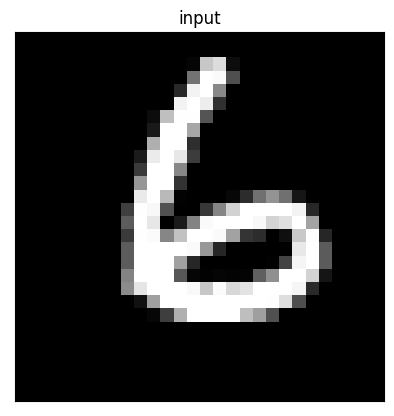

decoded_prototypes.shape:  torch.Size([10, 1, 28, 28])


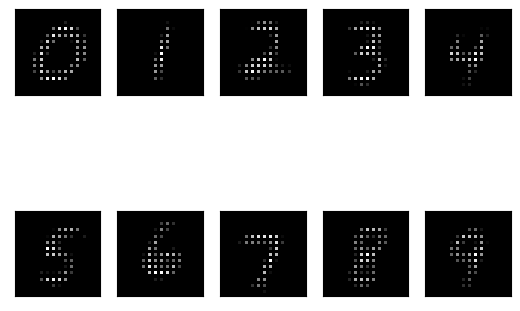

decoded_prototypes.shape:  torch.Size([1, 1, 28, 28])


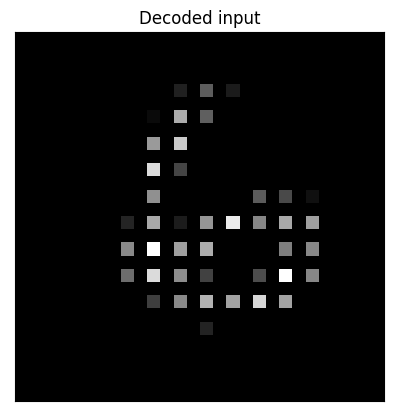

In [102]:
# get some random training images
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_data[0].unsqueeze(dim=0).shape)
# show images
fig = plt.figure()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.title("input")
plt.xticks([])
plt.yticks([])
plt.show()


example_data = example_data[0].unsqueeze(dim=0).cuda()
with torch.no_grad():
    encoded_input, decoded_input, output, prototype_distances, feature_vector_distances, prototype_vectors = model(example_data)
    model.presentPrototype(prototype_vectors, True)
    model.presentPrototype(encoded_input, False)

Performance Evalution

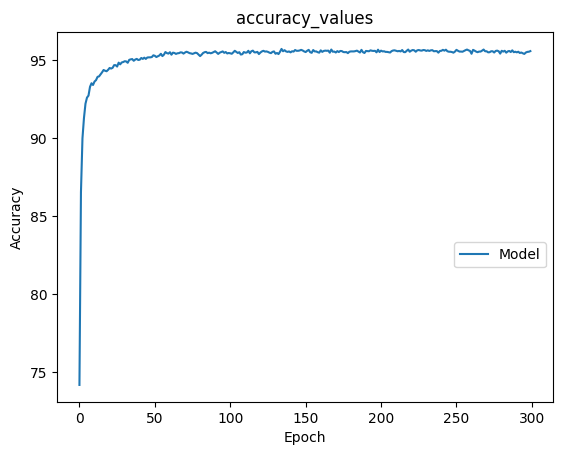

In [103]:
# First we check values we have so far
# print('accuracy_values', accuracy_values)
# print('epoch_number', epoch_number)
# Plot the data
plt.plot(epoch_number, accuracy_values, label='Model')  
plt.title('accuracy_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('Accuracy')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

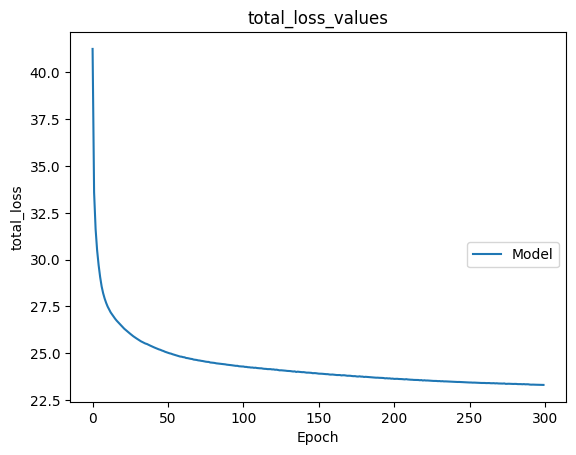

In [104]:
# Plot the data
plt.plot(epoch_number, total_loss_values, label='Model')  
plt.title('total_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('total_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

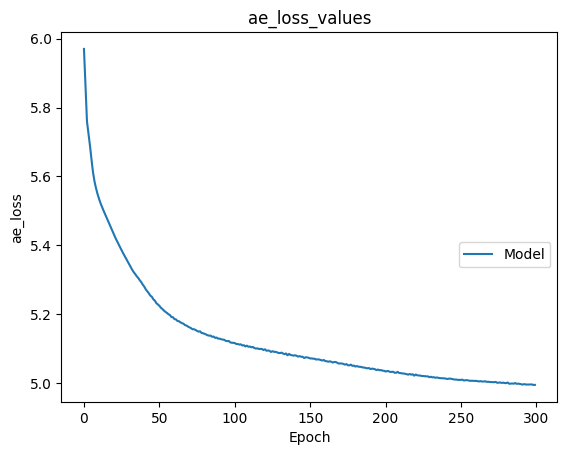

In [105]:
# Plot the data
plt.plot(epoch_number, ae_loss_values, label='Model')  
plt.title('ae_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('ae_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

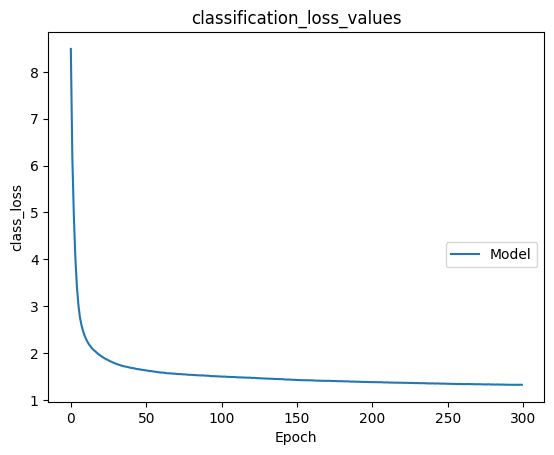

In [106]:
# Plot the data
plt.plot(epoch_number, class_loss_values, label='Model')  
plt.title('classification_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('class_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

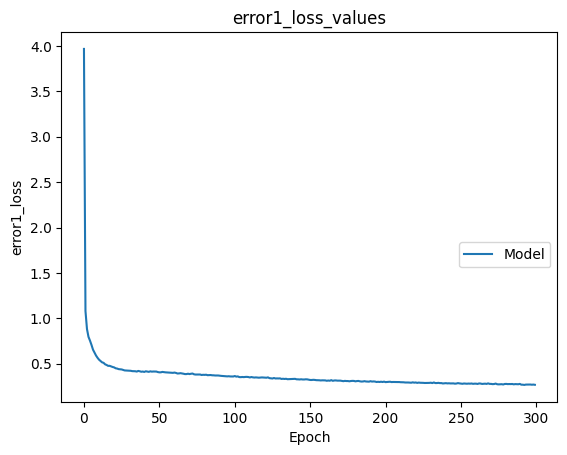

In [107]:
# Plot the data
plt.plot(epoch_number, error1_loss_values, label='Model')  
plt.title('error1_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error1_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

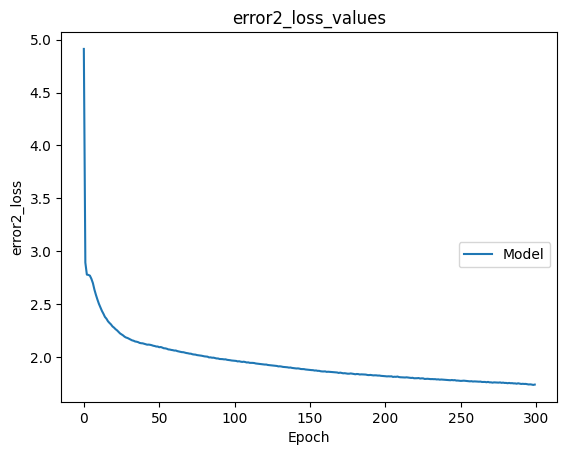

In [108]:
# Plot the data
plt.plot(epoch_number, error2_loss_values, label='Model')  
plt.title('error2_loss_values')
plt.xlabel('Epoch')#x轴
plt.ylabel('error2_loss')#y轴
# Add a legend
plt.legend(bbox_to_anchor=(1,0.45))

# Show the plot
plt.show()

#### Do more analysis on the final model to see how well it deals with each class

In [109]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
all_class_correct = list(0. for i in range(10))
all_class_total = list(0. for i in range(10))

with torch.no_grad():
    for images, labels in test_loader:
        images =images.cuda()
        labels =labels.cuda()
        
        _, _, outputs, _, _, _ = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)

        for i in range(batch_size):
            label = labels[i]
            all_class_correct[label] += c[i].item() # True is deemed as 1
            all_class_total[label] += 1



for i in range(10):
    print("all class total: ", all_class_total[i]," all class correct: ", all_class_correct[i])
    print('For network: Model Accuracy of %5s : %2d %%' % 
          (classes[i], 100 * all_class_correct[i] / all_class_total[i]))

all class total:  980.0  all class correct:  955.0
For network: Model Accuracy of     0 : 97 %
all class total:  1135.0  all class correct:  1125.0
For network: Model Accuracy of     1 : 99 %
all class total:  1032.0  all class correct:  971.0
For network: Model Accuracy of     2 : 94 %
all class total:  1010.0  all class correct:  954.0
For network: Model Accuracy of     3 : 94 %
all class total:  982.0  all class correct:  924.0
For network: Model Accuracy of     4 : 94 %
all class total:  892.0  all class correct:  861.0
For network: Model Accuracy of     5 : 96 %
all class total:  958.0  all class correct:  927.0
For network: Model Accuracy of     6 : 96 %
all class total:  1028.0  all class correct:  957.0
For network: Model Accuracy of     7 : 93 %
all class total:  974.0  all class correct:  912.0
For network: Model Accuracy of     8 : 93 %
all class total:  1009.0  all class correct:  970.0
For network: Model Accuracy of     9 : 96 %


#### Visualize the performance on each class

all_class_correct [97.44897959183673, 99.11894273127753, 94.0891472868217, 94.45544554455445, 94.09368635437882, 96.52466367713005, 96.76409185803757, 93.09338521400778, 93.63449691991786, 96.13478691774034]


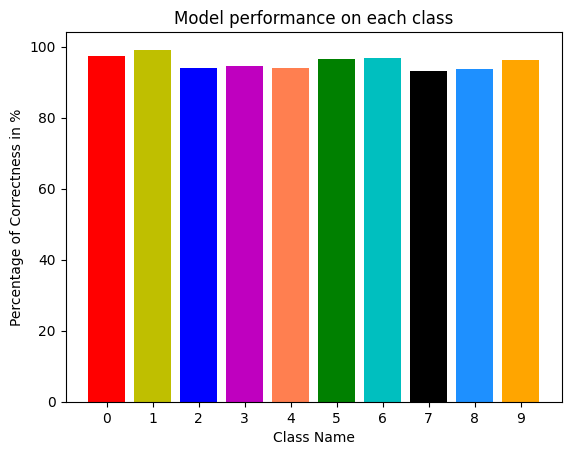

In [110]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for i, x in enumerate(all_class_correct):
    all_class_correct[i] = 100 * all_class_correct[i] / all_class_total[i]
print('all_class_correct', all_class_correct)


plt.bar(classes, all_class_correct, color=['r','y','b','m','coral','g','c','k','dodgerblue','orange'])
plt.title('Model performance on each class')
plt.xlabel('Class Name')#x轴
plt.ylabel('Percentage of Correctness in %')#y轴

plt.show()